# Mars Express Data Driven Digital Twin

Predicting thermal behavior of "Mars Express" satellite with data-based approach

In [2]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.model_selection as skms
from sklearn.linear_model import LinearRegression

import metrics

In [3]:
sns.set_theme()

In [4]:
path_to_data_dir = "./data/train_set/"

In [5]:
fileTypes = ['power', 'saaf', 'dmop', 'ftl', 'ltdata']

In [6]:
power_variables = ['NPWD2372', 'NPWD2401', 'NPWD2402', 'NPWD2451', 'NPWD2471', 'NPWD2472', 'NPWD2481', 'NPWD2482', 'NPWD2491', 'NPWD2501', 'NPWD2531', 'NPWD2532', 'NPWD2551', 'NPWD2552', 'NPWD2561', 'NPWD2562', 'NPWD2691', 'NPWD2692', 'NPWD2721', 'NPWD2722', 'NPWD2742', 'NPWD2771', 'NPWD2791', 'NPWD2792', 'NPWD2801', 'NPWD2802', 'NPWD2821', 'NPWD2851', 'NPWD2852', 'NPWD2871', 'NPWD2872', 'NPWD2881', 'NPWD2882']

In [7]:
year_of_interest = 1

## 1 - Data Loading

In [8]:
def getRawDataPath(path_to_data_dir,fileType, year):
    
    """
    Extracts dataFrame associated to the given parameters
    'path_to_data_dir' is the path to data directory
    'fileType' is 
    'year' is the number of martian year : 1, 2 or 3 ('int')
    """

    query = f"{path_to_data_dir}*{fileType}*"
    fileNameList = glob.glob(query)
    fileNameFirst = np.sort(fileNameList)[year - 1]

    return fileNameFirst

In [9]:
def prepare_power(data_path, str_subsample_min):
    # reading data from .csv file
    data = pd.read_csv(data_path, sep = ',')#, usecols = ['ut_ms', 'NPWD2451'])
    # converting ut_ms to date time
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]], unit = 'ms')
    data.set_index(data.columns[0], inplace = True)
    # sub-sampling
    data = data.resample(str_subsample_min).mean()
    return data

def prepare_saaf(data_path, str_subsample_min):
    
    data = pd.read_csv(data_path, sep = ',')        
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]], unit = 'ms')
    data.set_index(data.columns[0], inplace = True)
    data = data.resample(str_subsample_min).mean()
    
    return data

def prepare_dmop(data_path, str_subsample_min):

    data = pd.read_csv(data_path, sep = ',')
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]], unit = 'ms')

    # creating 'command' column associated to the 4 first characters
    data['command'] = data.apply(lambda x : x['subsystem'][:4], axis = 1)
    # one hot encoding
    data = pd.get_dummies(data[['ut_ms', 'command']])
    data.set_index(data.columns[0], inplace = True)
    data = data.resample(str_subsample_min).pad()
    return data

def prepare_ftl(data_path, str_subsample_min):
    
    data = pd.read_csv(data_path, sep = ',')
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]], unit = 'ms')

    # one hot encoding
    data = pd.get_dummies(data[['utb_ms', 'ute_ms', 'type', 'flagcomms']])
    data.set_index(data.columns[0], inplace = True)
    data = data.resample(str_subsample_min).pad()
    
    data = data.bfill()
    data['flagcomms'] = data['flagcomms'].astype('int')
    
    return data

def prepare_ltdata(data_path, str_subsample_min):
    
    data = pd.read_csv(data_path, sep = ',')
    data[data.columns[0]] = pd.to_datetime(data[data.columns[0]], unit = 'ms')
    data.set_index(data.columns[0], inplace = True)
    data = data.resample(str_subsample_min).pad()
    return data

def getPreparedDataFrames(directory_path, str_subsample_min):
    
    """
    Get all dataFrame ready to use
    """
    
    fileTypes = ['power', 'saaf', 'dmop', 'ftl', 'ltdata']
    year_of_interest = 1
    
    dfList = []
    
    for fileType in fileTypes:
        data_path = getRawDataPath(directory_path, fileType, year_of_interest)
        
        if fileType == 'power':
            data = prepare_power(data_path, str_subsample_min)
            
        elif fileType == 'saaf':
            data = prepare_saaf(data_path, str_subsample_min)
            
        elif fileType == 'dmop':
            data = prepare_dmop(data_path, str_subsample_min)
        
        elif fileType == 'ftl':
            data = prepare_ftl(data_path, str_subsample_min)
        
        elif fileType == 'ltdata':
            data = prepare_ltdata(data_path, str_subsample_min)
            
        dfList.append(data)
    return dfList

In [10]:
dfList = getPreparedDataFrames(path_to_data_dir, '60min')
dfList[0]

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,NPWD2792,NPWD2801,NPWD2802,NPWD2821,NPWD2851,NPWD2852,NPWD2871,NPWD2872,NPWD2881,NPWD2882
ut_ms,,,,,,,,,,,,,,,,,,,,,
2008-08-22 00:00:00,0.133582,0.001552,0.175436,0.657240,0.000747,0.000661,0.000585,0.001927,0.244648,0.005277,...,0.000573,0.001526,0.159719,0.005753,0.005273,0.000529,0.000525,0.000762,0.006765,0.003382
2008-08-22 01:00:00,0.217001,0.001498,0.175888,0.854918,0.000717,0.000628,0.000551,0.001834,0.230870,0.005010,...,0.000560,0.001484,0.046897,0.005607,0.005035,0.000510,0.000503,0.000728,0.006595,0.003268
2008-08-22 02:00:00,0.155922,0.001503,0.175389,1.079016,0.000719,0.000636,0.000568,0.001856,0.202746,0.005135,...,0.000573,0.001508,0.281516,0.005685,0.005097,0.000514,0.000513,0.000731,0.006571,0.003296
2008-08-22 03:00:00,0.081440,0.001532,0.175324,0.720677,0.000742,0.000647,0.000570,0.001892,0.212218,0.005162,...,0.000578,0.001521,0.142337,0.005745,0.005249,0.000527,0.000517,0.000747,0.006734,0.003423
2008-08-22 04:00:00,0.103773,0.001505,0.174224,0.828578,0.000738,0.000642,0.000560,0.001879,0.228923,0.005170,...,0.000566,0.001521,0.057978,0.005753,0.005176,0.000525,0.000525,0.000740,0.006685,0.003370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-09 19:00:00,0.120902,0.001487,0.174948,0.479883,0.000721,0.000632,0.000563,0.001847,0.219967,0.005109,...,0.000560,0.001498,0.068240,0.005646,0.357885,0.000509,0.000507,0.000724,0.006503,0.003268
2010-07-09 20:00:00,0.132818,0.001474,0.175715,0.321634,0.000714,0.000626,0.000554,0.001827,0.202872,0.005028,...,0.000553,0.001474,0.181942,0.005547,0.145607,0.000502,0.000498,0.000714,0.006457,0.003227
2010-07-09 21:00:00,0.147228,0.001474,0.175935,0.527533,0.000714,0.000626,0.000554,0.001827,0.223830,0.005028,...,0.000553,0.001474,0.082268,0.005547,0.361977,0.000502,0.000498,0.000714,0.006457,0.003227


In [11]:
dfList[1]

,sa,sx,sy,sz
ut_ms,,,,
2008-08-22 00:00:00,0.339355,14.551129,90.339355,104.548871
2008-08-22 01:00:00,6.619310,18.012184,90.500460,90.396437
2008-08-22 02:00:00,30.927137,37.511806,64.618150,86.910793
2008-08-22 03:00:00,1.534306,15.217917,89.967083,105.197917
2008-08-22 04:00:00,0.339672,14.523934,90.339672,104.520492
...,...,...,...,...
2010-07-09 19:00:00,0.255000,28.165417,90.255000,118.165000
2010-07-09 20:00:00,0.255000,28.164833,90.255000,118.162250
2010-07-09 21:00:00,0.255000,28.155000,90.255000,118.155000


In [12]:
dfList[2]

,command_AAAA,command_AHHH,command_AMMM,command_AOOO,command_APSF,command_APWF,command_ASEQ,command_ASSS,command_ASXX,command_ATMB,...,command_MPER,command_PDNE,command_PDNS,command_PENE,command_PENS,command_PPNE,command_PPNS,command_SCMN,command_UPBE,command_UPBS
ut_ms,,,,,,,,,,,,,,,,,,,,,
2008-08-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-22 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 02:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-09 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-09 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-09 21:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
dfList[3]

,ute_ms,flagcomms,type_ACROSS_TRACK,type_D1PVMC,type_D2PLND,type_D3POCM,type_D4PNPO,type_D5PPHB,type_EARTH,type_INERTIAL,type_MAINTENANCE,type_NADIR,type_RADIO_SCIENCE,type_SLEW,type_SPECULAR,type_WARMUP
utb_ms,,,,,,,,,,,,,,,,
2008-08-22 00:00:00,1.219370e+12,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 01:00:00,1.219370e+12,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-22 02:00:00,1.219373e+12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2008-08-22 03:00:00,1.219375e+12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2008-08-22 04:00:00,1.219381e+12,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-09 19:00:00,1.278712e+12,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-09 20:00:00,1.278712e+12,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-09 21:00:00,1.278712e+12,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
dfList[4]

,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min
ut_ms,,,,,,
2008-08-22 00:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000
2008-08-22 01:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000
2008-08-22 02:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000
2008-08-22 03:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000
2008-08-22 04:00:00,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.400000
...,...,...,...,...,...,...
2010-07-08 20:00:00,2.422058e+08,2.755380e+08,33.383248,521.113675,0.000000,12.583333
2010-07-08 21:00:00,2.422058e+08,2.755380e+08,33.383248,521.113675,0.000000,12.583333
2010-07-08 22:00:00,2.422058e+08,2.755380e+08,33.383248,521.113675,0.000000,12.583333


In [15]:
comb = pd.concat(dfList, axis = 1)
comb

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,type_RADIO_SCIENCE,type_SLEW,type_SPECULAR,type_WARMUP,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min
ut_ms,,,,,,,,,,,,,,,,,,,,,
2008-08-22 00:00:00,0.133582,0.001552,0.175436,0.657240,0.000747,0.000661,0.000585,0.001927,0.244648,0.005277,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 01:00:00,0.217001,0.001498,0.175888,0.854918,0.000717,0.000628,0.000551,0.001834,0.230870,0.005010,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 02:00:00,0.155922,0.001503,0.175389,1.079016,0.000719,0.000636,0.000568,0.001856,0.202746,0.005135,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 03:00:00,0.081440,0.001532,0.175324,0.720677,0.000742,0.000647,0.000570,0.001892,0.212218,0.005162,...,0.0,1.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 04:00:00,0.103773,0.001505,0.174224,0.828578,0.000738,0.000642,0.000560,0.001879,0.228923,0.005170,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-09 19:00:00,0.120902,0.001487,0.174948,0.479883,0.000721,0.000632,0.000563,0.001847,0.219967,0.005109,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-09 20:00:00,0.132818,0.001474,0.175715,0.321634,0.000714,0.000626,0.000554,0.001827,0.202872,0.005028,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-09 21:00:00,0.147228,0.001474,0.175935,0.527533,0.000714,0.000626,0.000554,0.001827,0.223830,0.005028,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## 2 - Interpolation

In [16]:
def interpolateData(dfList):

    '''
    Concatenates the DataFrames list, sorts concatenated data by dataFrame.
    Computes linear interpolation for quantitative data, pad interpolation
    for categorical data.

    Returns concatenated data.
    '''

    # concatenation of all prepared dataFrames
    combinedData = pd.concat(dfList, axis = 1)
    
    col = list(combinedData.columns)
    print("col = ", col)

    for c in col :
        # 'pad' interpolation for categorical data
        if c.split('_')[0] == 'type' or c == 'flagcomms' or c == 'command' :
            combinedData[c] = combinedData[c].interpolate(method = 'pad')
        # 'linear' interpolation for quantitative data
        else :
            combinedData[c] = combinedData[c].interpolate(method = 'linear')
    
    return combinedData

In [17]:
combinedData = interpolateData(dfList)
combinedData = combinedData.dropna()
combinedData

col =  ['NPWD2372', 'NPWD2401', 'NPWD2402', 'NPWD2451', 'NPWD2471', 'NPWD2472', 'NPWD2481', 'NPWD2482', 'NPWD2491', 'NPWD2501', 'NPWD2531', 'NPWD2532', 'NPWD2551', 'NPWD2552', 'NPWD2561', 'NPWD2562', 'NPWD2691', 'NPWD2692', 'NPWD2721', 'NPWD2722', 'NPWD2742', 'NPWD2771', 'NPWD2791', 'NPWD2792', 'NPWD2801', 'NPWD2802', 'NPWD2821', 'NPWD2851', 'NPWD2852', 'NPWD2871', 'NPWD2872', 'NPWD2881', 'NPWD2882', 'sa', 'sx', 'sy', 'sz', 'command_AAAA', 'command_AHHH', 'command_AMMM', 'command_AOOO', 'command_APSF', 'command_APWF', 'command_ASEQ', 'command_ASSS', 'command_ASXX', 'command_ATMB', 'command_ATTT', 'command_AVVV', 'command_AXXX', 'command_MAPO', 'command_MOCE', 'command_MOCS', 'command_MPER', 'command_PDNE', 'command_PDNS', 'command_PENE', 'command_PENS', 'command_PPNE', 'command_PPNS', 'command_SCMN', 'command_UPBE', 'command_UPBS', 'ute_ms', 'flagcomms', 'type_ACROSS_TRACK', 'type_D1PVMC', 'type_D2PLND', 'type_D3POCM', 'type_D4PNPO', 'type_D5PPHB', 'type_EARTH', 'type_INERTIAL', 'type_

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,type_RADIO_SCIENCE,type_SLEW,type_SPECULAR,type_WARMUP,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min
ut_ms,,,,,,,,,,,,,,,,,,,,,
2008-08-22 01:00:00,0.217001,0.001498,0.175888,0.854918,0.000717,0.000628,0.000551,0.001834,0.230870,0.005010,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 02:00:00,0.155922,0.001503,0.175389,1.079016,0.000719,0.000636,0.000568,0.001856,0.202746,0.005135,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 03:00:00,0.081440,0.001532,0.175324,0.720677,0.000742,0.000647,0.000570,0.001892,0.212218,0.005162,...,0.0,1.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 04:00:00,0.103773,0.001505,0.174224,0.828578,0.000738,0.000642,0.000560,0.001879,0.228923,0.005170,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 05:00:00,0.118108,0.001555,0.175653,1.011065,0.000740,0.000640,0.000582,0.001951,0.200921,0.005216,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-09 19:00:00,0.120902,0.001487,0.174948,0.479883,0.000721,0.000632,0.000563,0.001847,0.219967,0.005109,...,0.0,0.0,0.0,0.0,2.420694e+08,2.765641e+08,33.267254,521.701215,0.000000,12.2
2010-07-09 20:00:00,0.132818,0.001474,0.175715,0.321634,0.000714,0.000626,0.000554,0.001827,0.202872,0.005028,...,0.0,0.0,0.0,0.0,2.420694e+08,2.765641e+08,33.267254,521.701215,0.000000,12.2
2010-07-09 21:00:00,0.147228,0.001474,0.175935,0.527533,0.000714,0.000626,0.000554,0.001827,0.223830,0.005028,...,0.0,0.0,0.0,0.0,2.420694e+08,2.765641e+08,33.267254,521.701215,0.000000,12.2


## 3 - Constructing train and test set for models

### 3.1 - Separating X and y

In [20]:
X = combinedData.copy()
Y = X[power_variables]
X.drop(power_variables, axis =1) # drop

,sa,sx,sy,sz,command_AAAA,command_AHHH,command_AMMM,command_AOOO,command_APSF,command_APWF,...,type_RADIO_SCIENCE,type_SLEW,type_SPECULAR,type_WARMUP,sunmars_km,earthmars_km,sunmarsearthangle_deg,solarconstantmars,eclipseduration_min,occultationduration_min
ut_ms,,,,,,,,,,,,,,,,,,,,,
2008-08-22 01:00:00,6.619310,18.012184,90.500460,90.396437,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 02:00:00,30.927137,37.511806,64.618150,86.910793,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 03:00:00,1.534306,15.217917,89.967083,105.197917,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 04:00:00,0.339672,14.523934,90.339672,104.520492,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
2008-08-22 05:00:00,0.339508,14.516557,90.339508,104.511311,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.419389e+08,3.557560e+08,19.565076,522.263999,4.166667,27.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-09 19:00:00,0.255000,28.165417,90.255000,118.165000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.420694e+08,2.765641e+08,33.267254,521.701215,0.000000,12.2
2010-07-09 20:00:00,0.255000,28.164833,90.255000,118.162250,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.420694e+08,2.765641e+08,33.267254,521.701215,0.000000,12.2
2010-07-09 21:00:00,0.255000,28.155000,90.255000,118.155000,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.420694e+08,2.765641e+08,33.267254,521.701215,0.000000,12.2


In [21]:
Y

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,NPWD2792,NPWD2801,NPWD2802,NPWD2821,NPWD2851,NPWD2852,NPWD2871,NPWD2872,NPWD2881,NPWD2882
ut_ms,,,,,,,,,,,,,,,,,,,,,
2008-08-22 01:00:00,0.217001,0.001498,0.175888,0.854918,0.000717,0.000628,0.000551,0.001834,0.230870,0.005010,...,0.000560,0.001484,0.046897,0.005607,0.005035,0.000510,0.000503,0.000728,0.006595,0.003268
2008-08-22 02:00:00,0.155922,0.001503,0.175389,1.079016,0.000719,0.000636,0.000568,0.001856,0.202746,0.005135,...,0.000573,0.001508,0.281516,0.005685,0.005097,0.000514,0.000513,0.000731,0.006571,0.003296
2008-08-22 03:00:00,0.081440,0.001532,0.175324,0.720677,0.000742,0.000647,0.000570,0.001892,0.212218,0.005162,...,0.000578,0.001521,0.142337,0.005745,0.005249,0.000527,0.000517,0.000747,0.006734,0.003423
2008-08-22 04:00:00,0.103773,0.001505,0.174224,0.828578,0.000738,0.000642,0.000560,0.001879,0.228923,0.005170,...,0.000566,0.001521,0.057978,0.005753,0.005176,0.000525,0.000525,0.000740,0.006685,0.003370
2008-08-22 05:00:00,0.118108,0.001555,0.175653,1.011065,0.000740,0.000640,0.000582,0.001951,0.200921,0.005216,...,0.000587,0.001545,0.176873,0.005795,0.005249,0.000536,0.000538,0.000740,0.006780,0.003354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-07-09 19:00:00,0.120902,0.001487,0.174948,0.479883,0.000721,0.000632,0.000563,0.001847,0.219967,0.005109,...,0.000560,0.001498,0.068240,0.005646,0.357885,0.000509,0.000507,0.000724,0.006503,0.003268
2010-07-09 20:00:00,0.132818,0.001474,0.175715,0.321634,0.000714,0.000626,0.000554,0.001827,0.202872,0.005028,...,0.000553,0.001474,0.181942,0.005547,0.145607,0.000502,0.000498,0.000714,0.006457,0.003227
2010-07-09 21:00:00,0.147228,0.001474,0.175935,0.527533,0.000714,0.000626,0.000554,0.001827,0.223830,0.005028,...,0.000553,0.001474,0.082268,0.005547,0.361977,0.000502,0.000498,0.000714,0.006457,0.003227


In [22]:
y = Y['NPWD2451']
y

ut_ms
2008-08-22 01:00:00    0.854918
2008-08-22 02:00:00    1.079016
2008-08-22 03:00:00    0.720677
2008-08-22 04:00:00    0.828578
2008-08-22 05:00:00    1.011065
                         ...   
2010-07-09 19:00:00    0.479883
2010-07-09 20:00:00    0.321634
2010-07-09 21:00:00    0.527533
2010-07-09 22:00:00    0.359964
2010-07-09 23:00:00    0.441354
Freq: 60T, Name: NPWD2451, Length: 16487, dtype: float64

### 3.2 - Sliptting [X,y] into [X_train, X_test, y_train, y_test]

In [23]:
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.25, random_state=42)

## 4 - Model Run

In [24]:
reg = LinearRegression().fit(X_train, y_train)
predict = reg.predict(X_test)

predict = pd.Series(predict)

## 5 - Error plot

In [25]:
# y_test['date'] = y_test.index
y_test

ut_ms
2010-01-11 03:00:00    0.837740
2009-09-24 16:00:00    0.441130
2009-07-17 23:00:00    0.260035
2009-08-03 01:00:00    0.513102
2009-08-15 11:00:00    0.248675
                         ...   
2008-09-04 19:00:00    0.887556
2008-11-04 11:00:00    1.030302
2008-09-24 21:00:00    0.434076
2008-11-12 11:00:00    0.947238
2008-12-29 21:00:00    0.550960
Name: NPWD2451, Length: 4122, dtype: float64

In [26]:
y_test.values

array([0.83773968, 0.4411299 , 0.26003463, ..., 0.43407585, 0.94723821,
       0.55095964])

In [27]:
predict

0       0.837728
1       0.441195
2       0.260018
3       0.513093
4       0.248635
          ...   
4117    0.887500
4118    1.030286
4119    0.434060
4120    0.947246
4121    0.550891
Length: 4122, dtype: float64

In [28]:
predict.values

array([0.8377277 , 0.44119517, 0.26001769, ..., 0.43406009, 0.94724606,
       0.55089058])

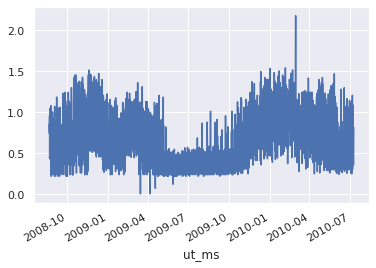

In [29]:
y_test.plot()

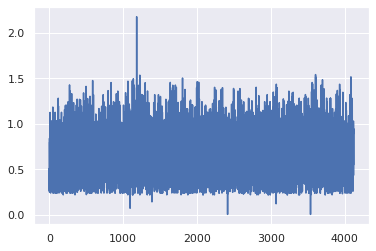

In [30]:
predict.plot()

In [31]:
err = y_test.values - predict.values

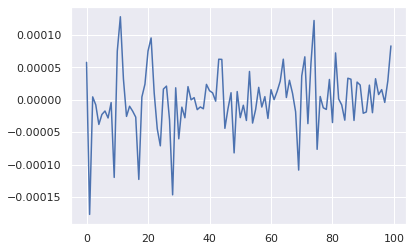

In [51]:
sns.lineplot(data = err[200:300])

/home/barney/.local/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


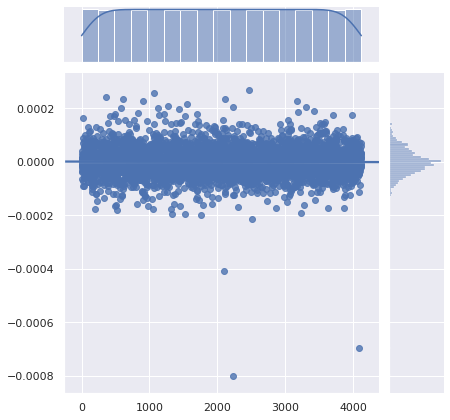

In [52]:
sns.jointplot(data = err, kind="reg", truncate=False)

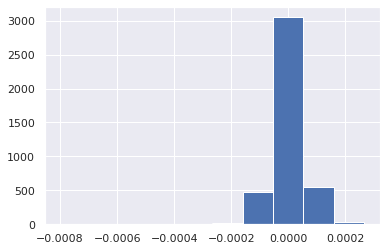

In [53]:
pd.Series(err).hist()

[Text(0, 0.5, 'nb of values'), Text(0.5, 0, 'Absolute error')]

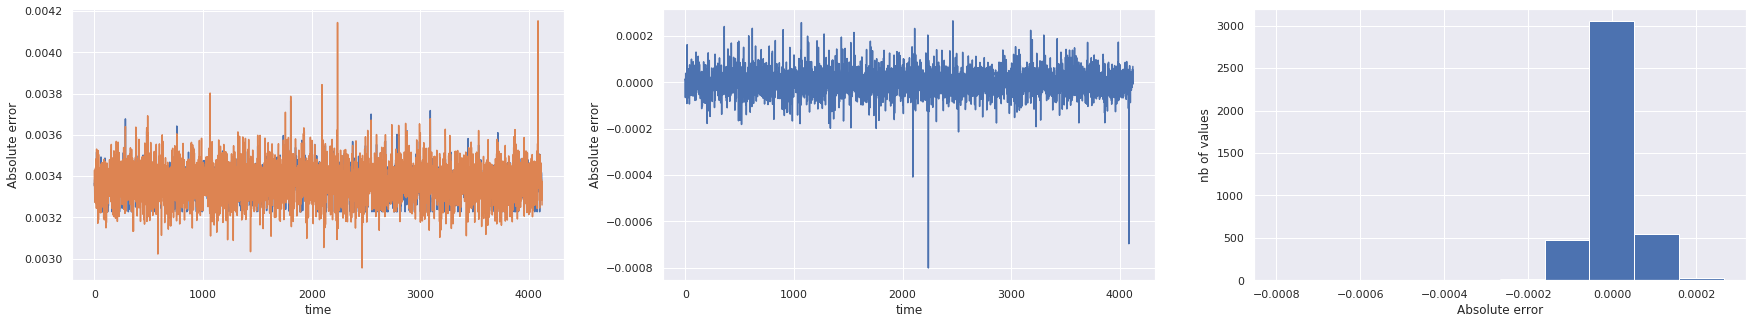

In [73]:
fig, ax = plt.subplots(1,3, figsize = (30,5))
fig.suptitle('')
ax[0].plot(y_test.values)
ax[0].plot(predict.values)
ax[1].plot(err)
ax[2].hist(err)

ax[0].set(xlabel = 'time', ylabel = 'Absolute error')
ax[1].set(xlabel = 'time', ylabel = 'Absolute error')
ax[2].set(xlabel = 'Absolute error', ylabel = 'nb of values')

### Displaying absolute error for each column of 'power' data | year 1 | sklearn LinearRegression model

<ipython-input-74-50af44d0bc98>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3, figsize = (30,5))
<ipython-input-74-50af44d0bc98>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3, figsize = (30,5))
<ipython-input-74-50af44d0bc98>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

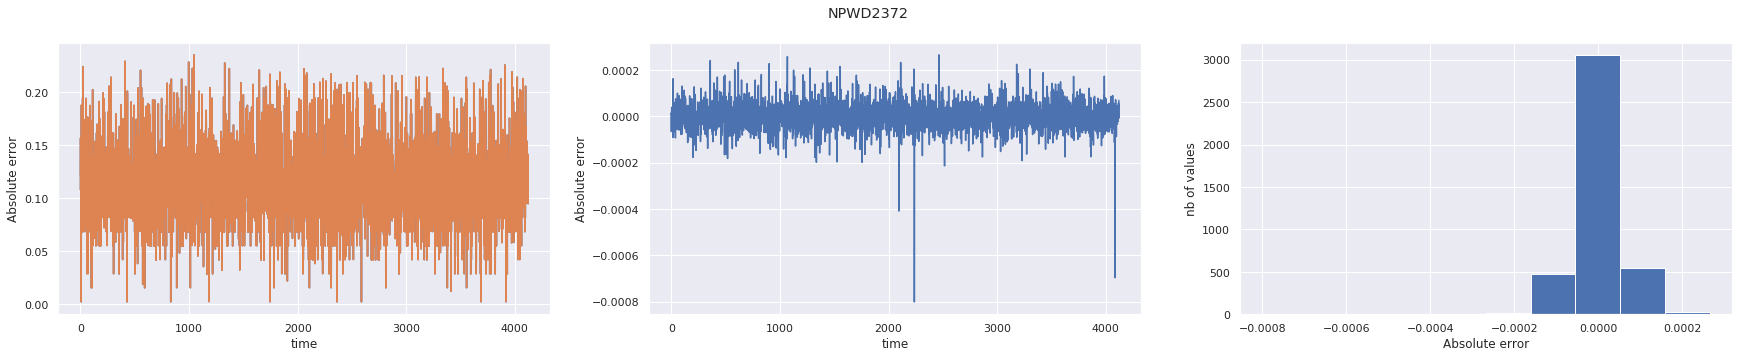

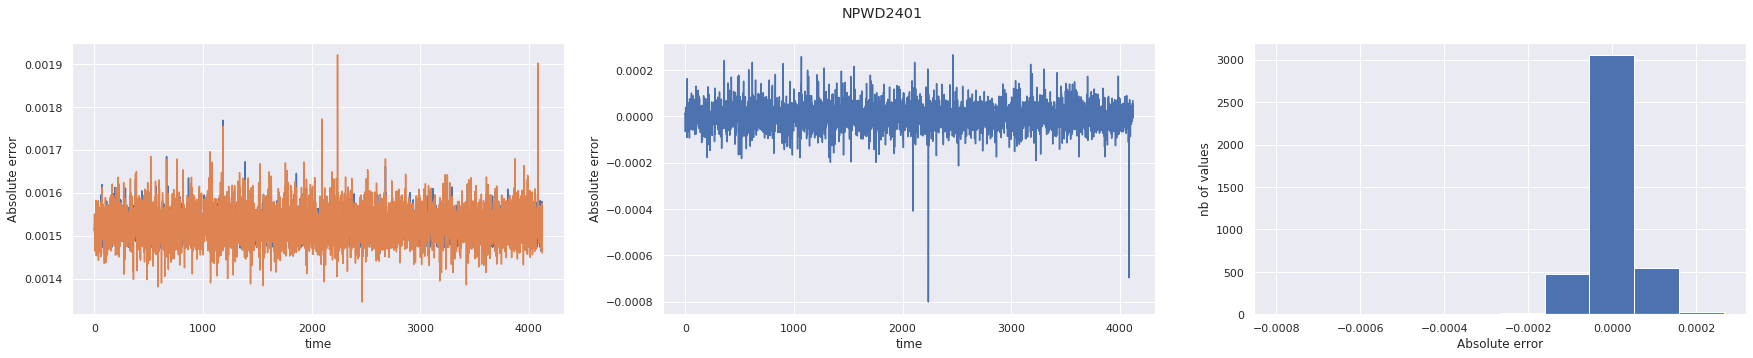

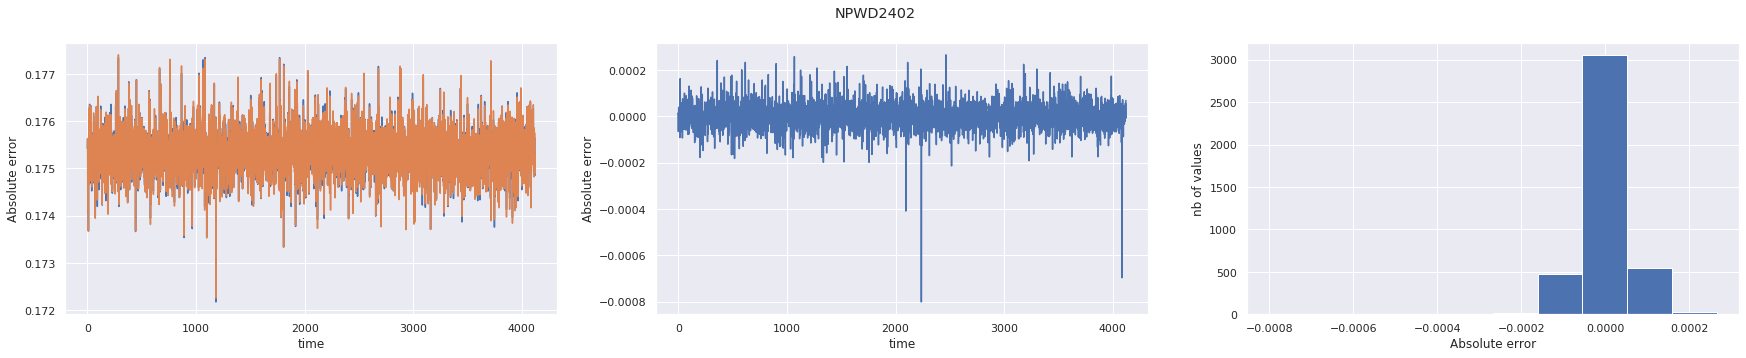

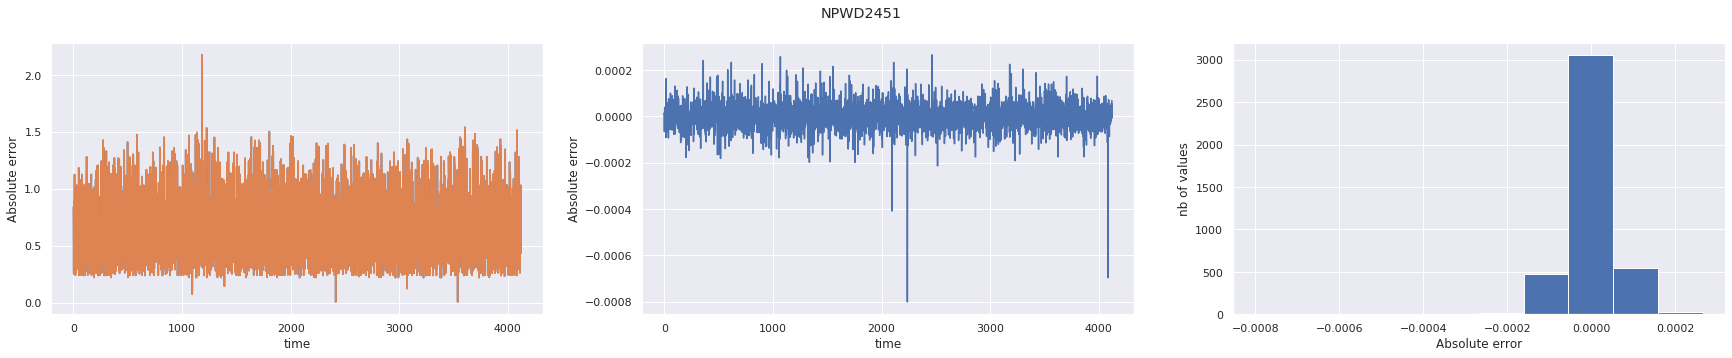

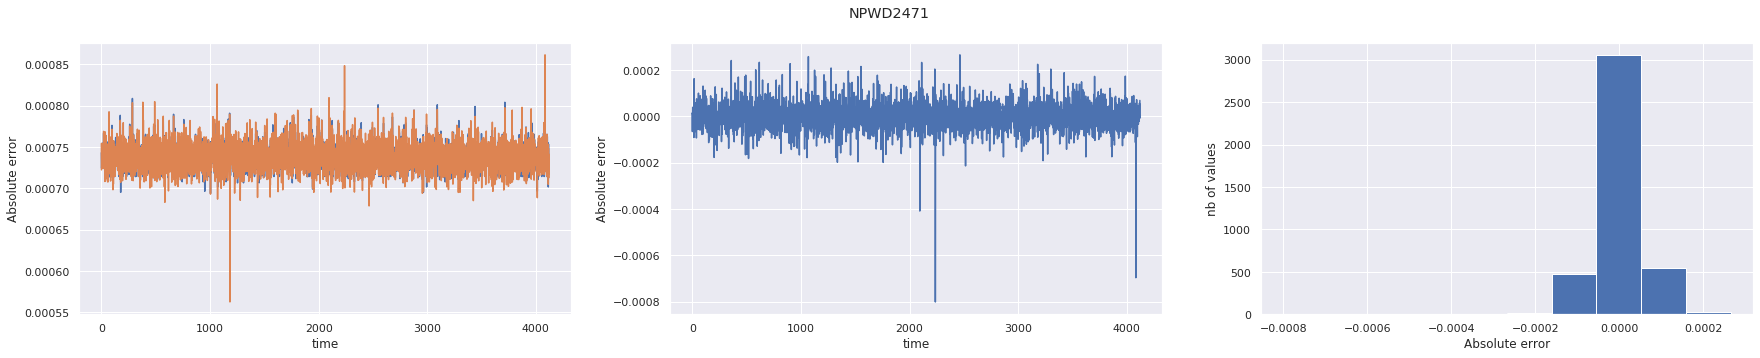

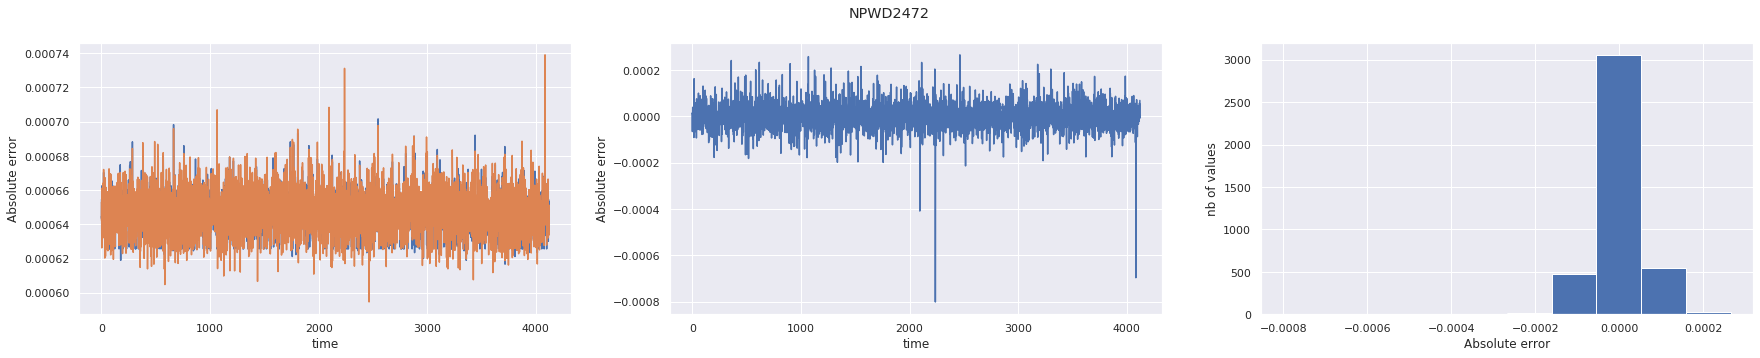

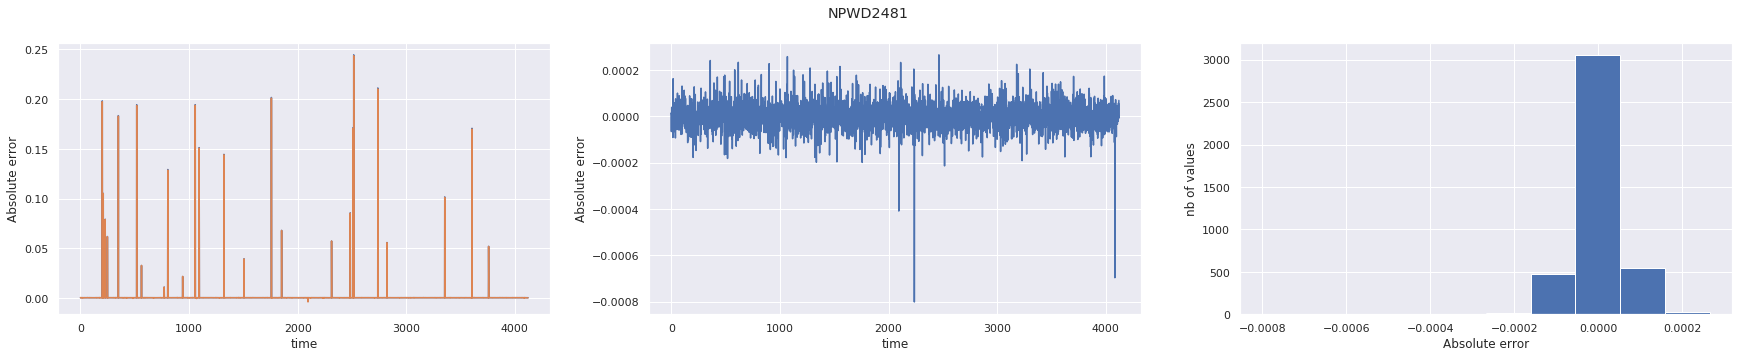

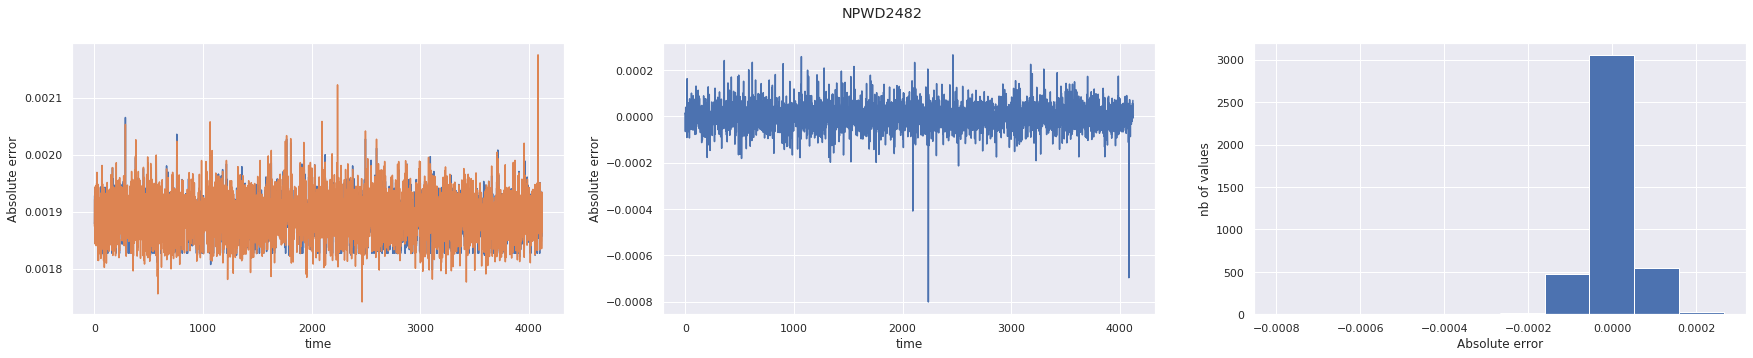

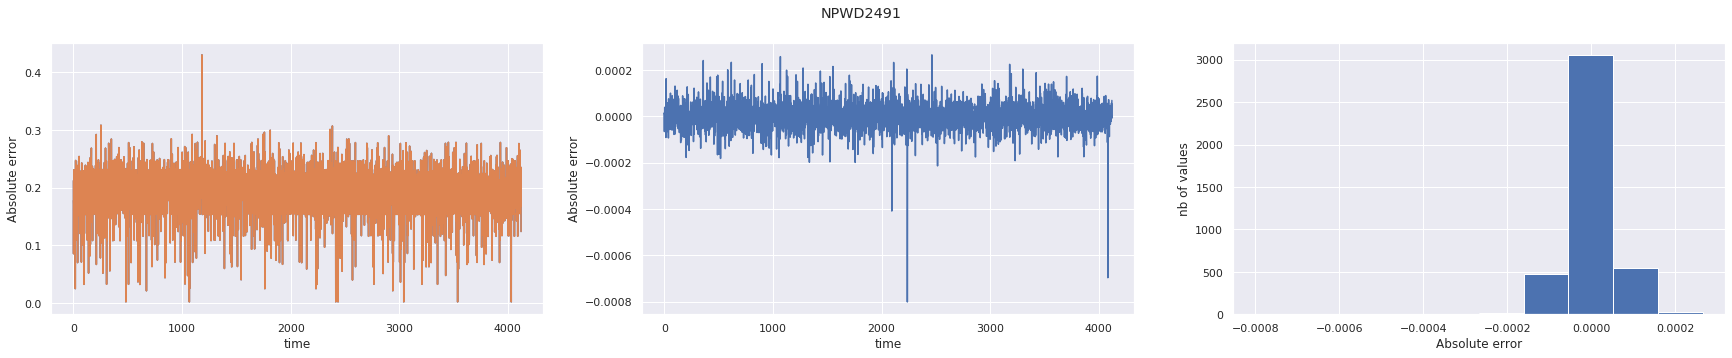

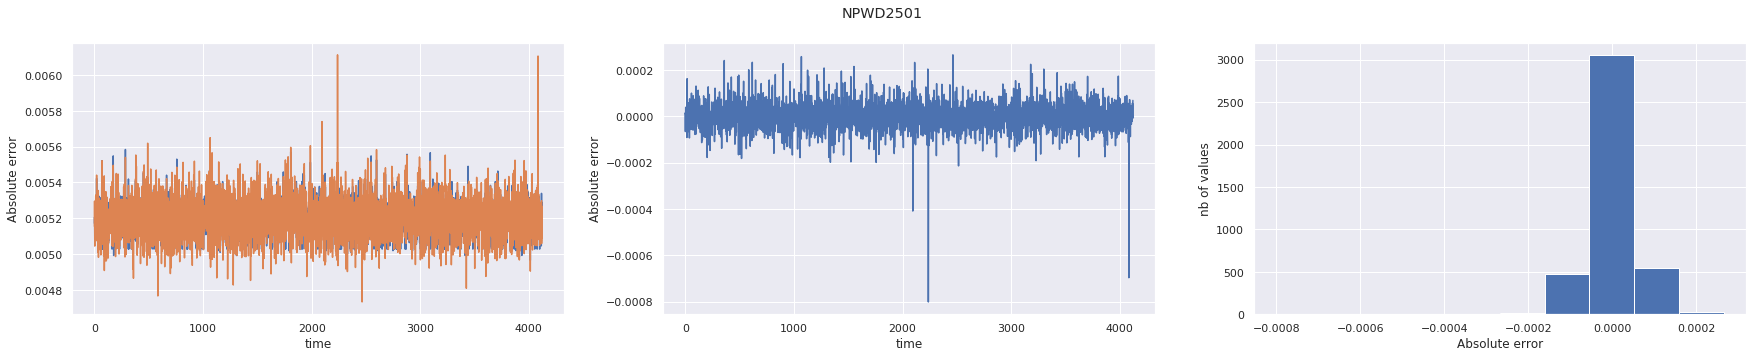

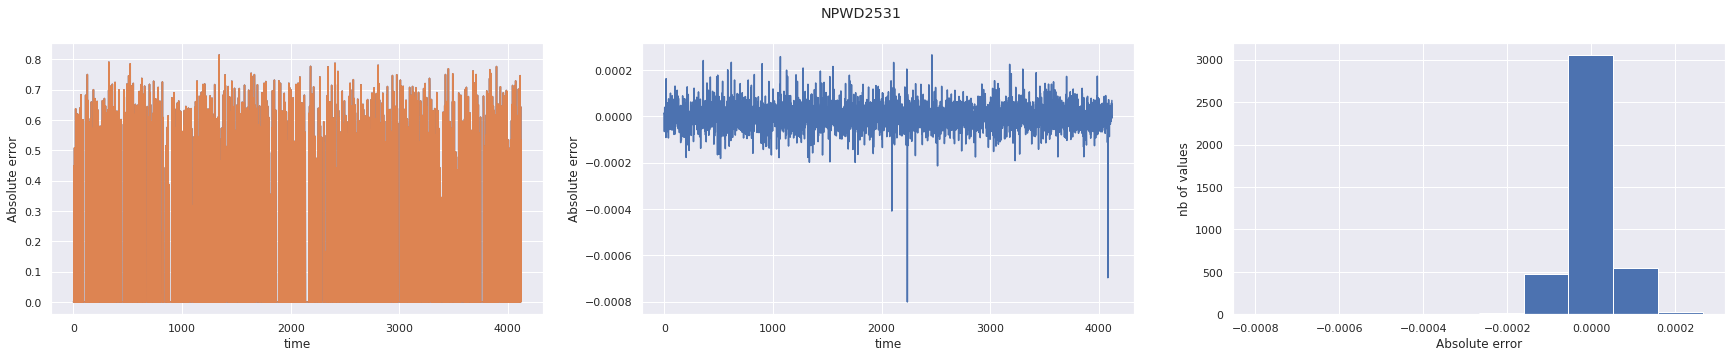

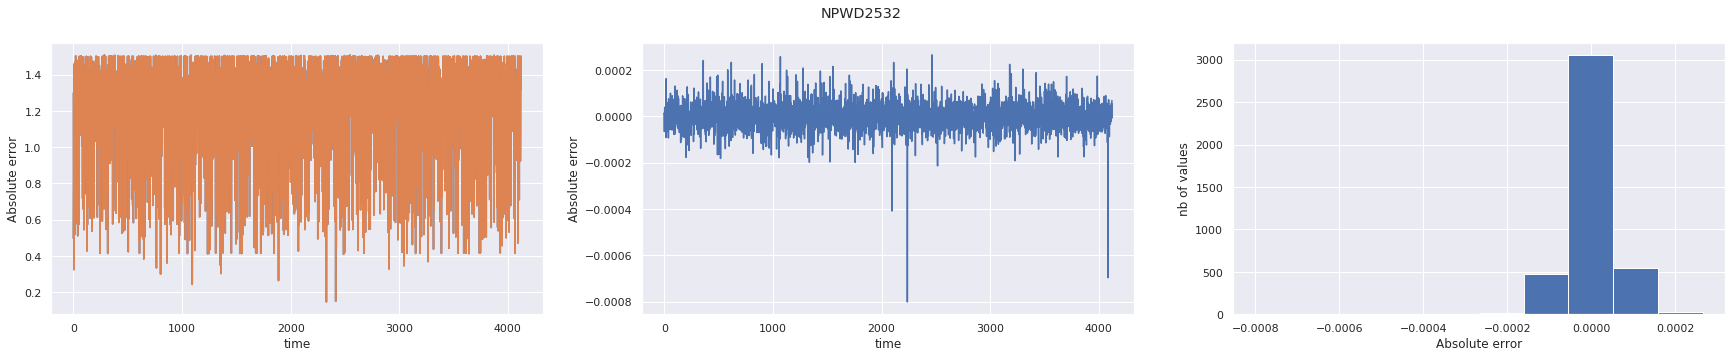

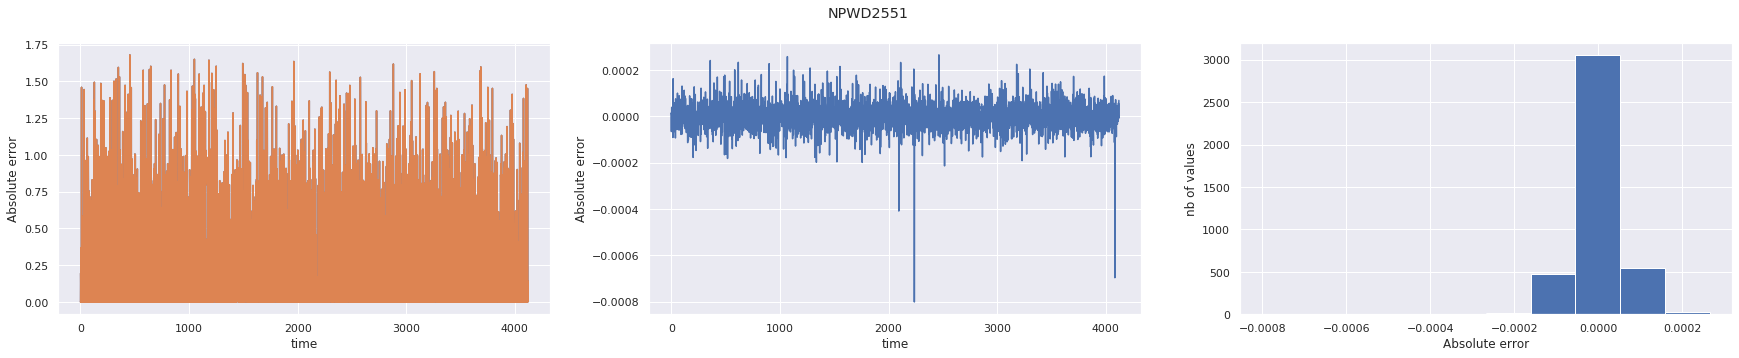

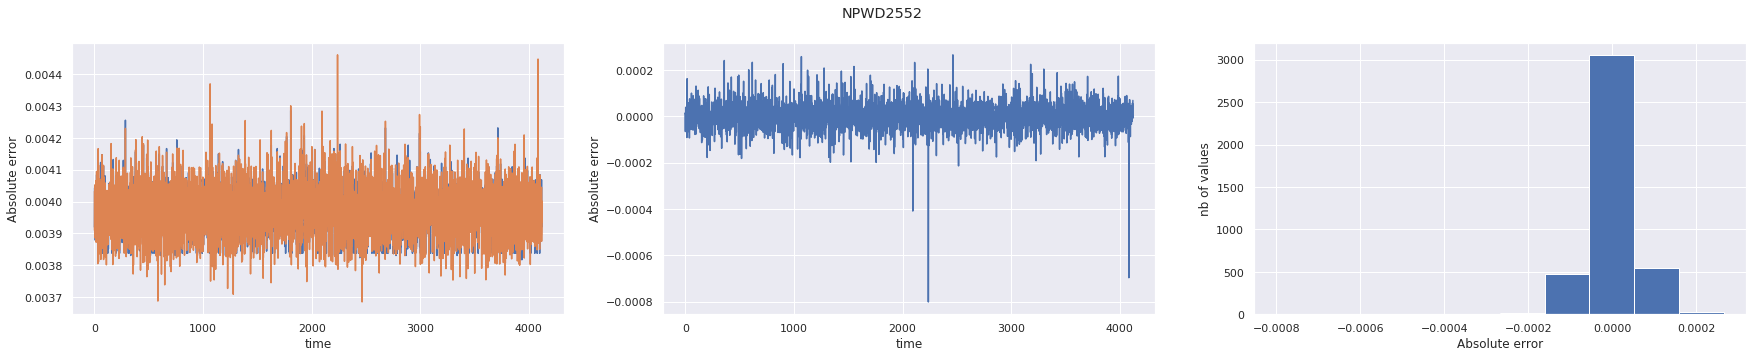

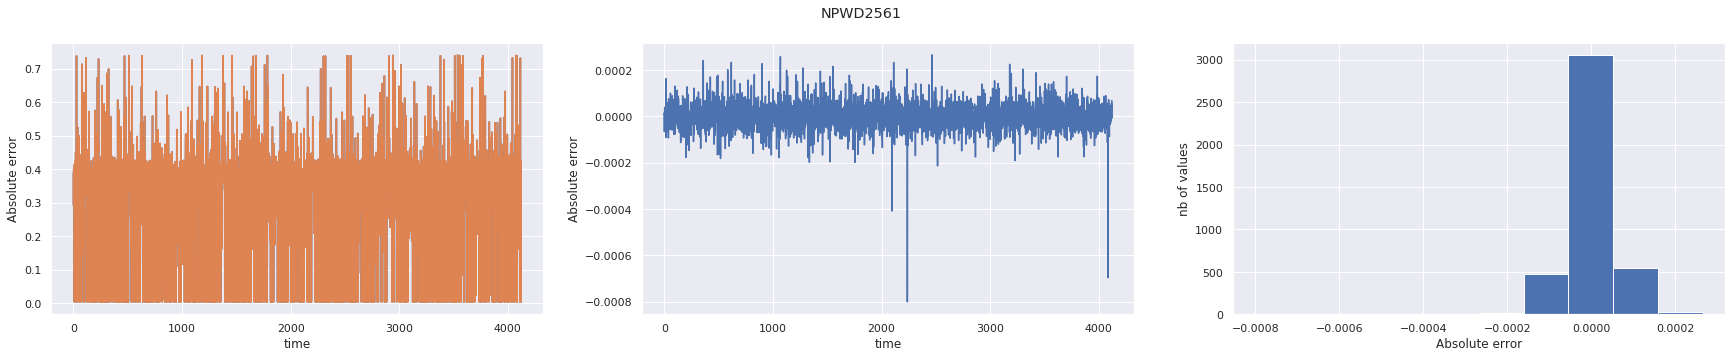

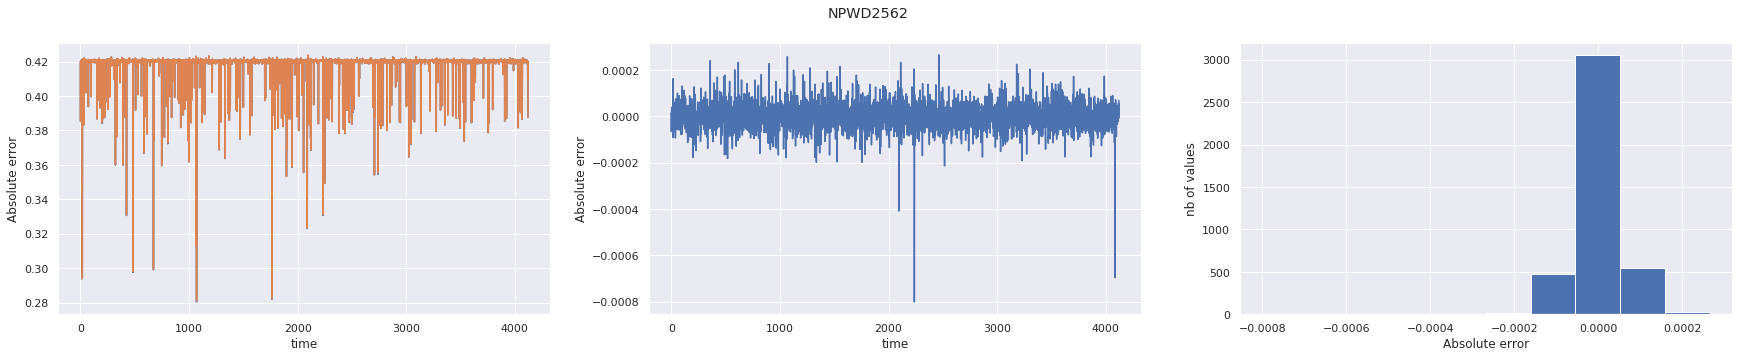

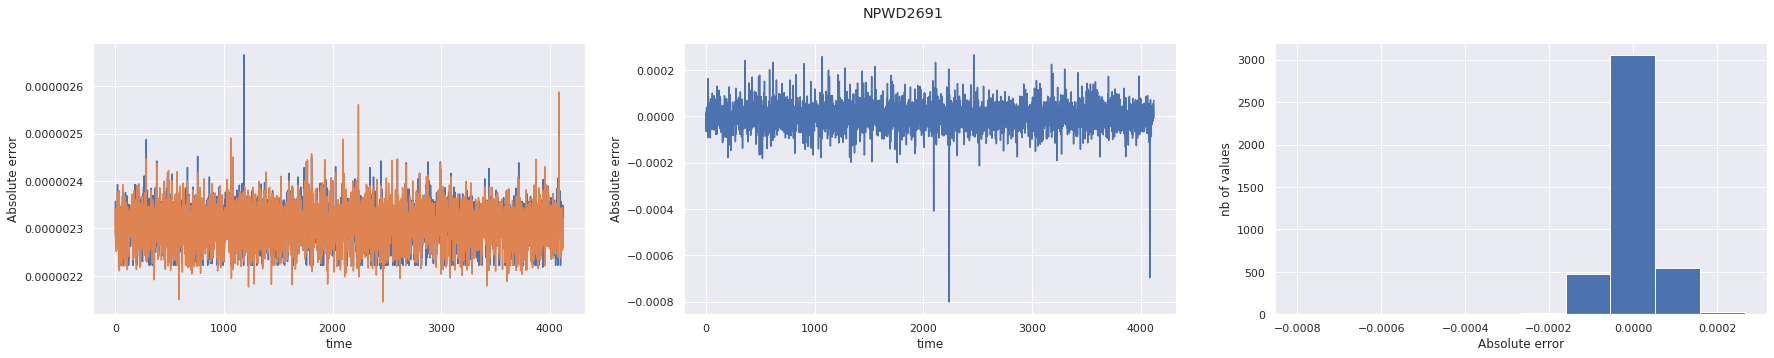

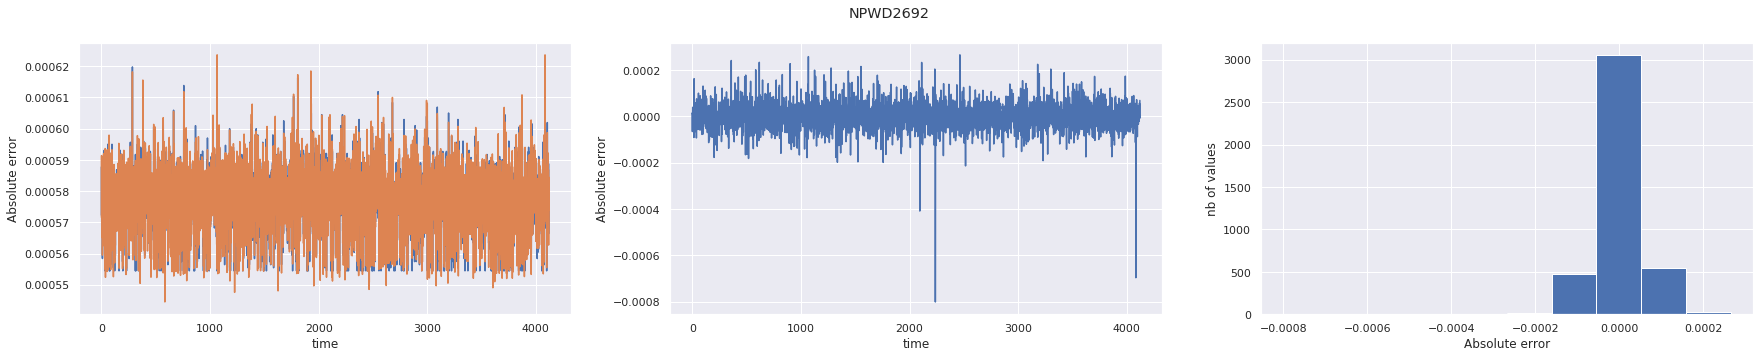

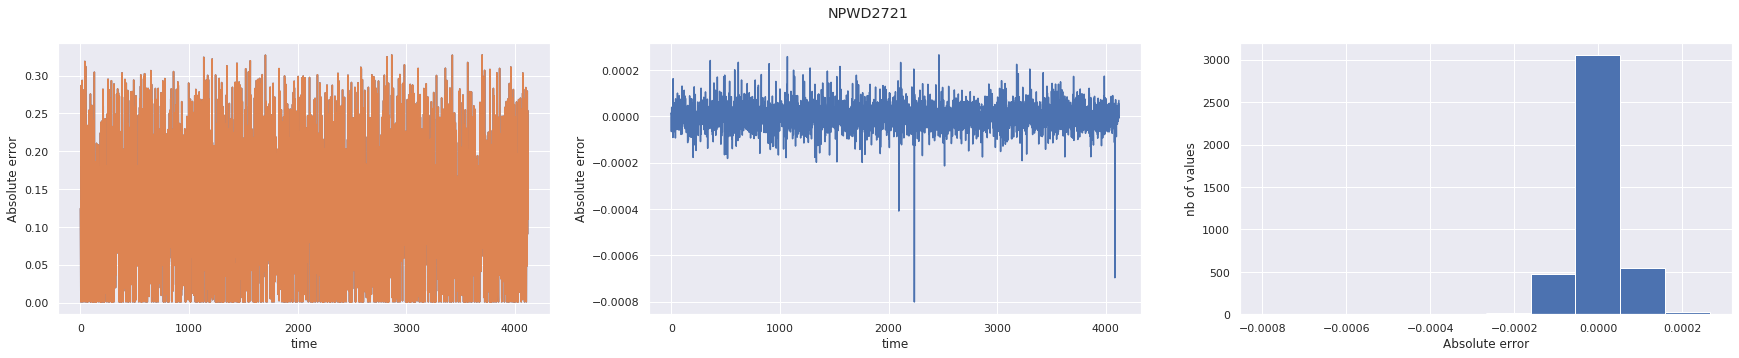

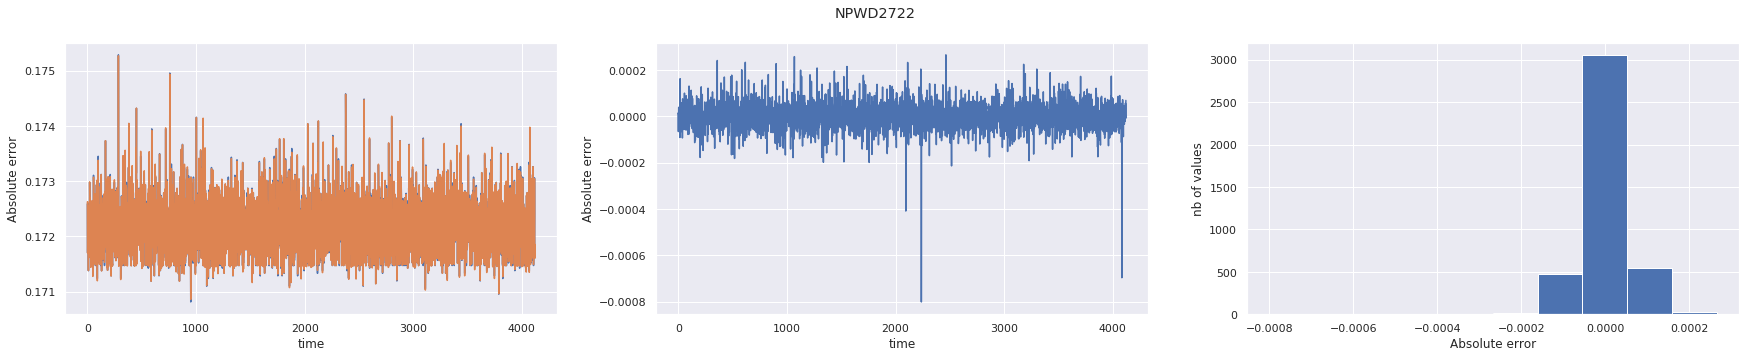

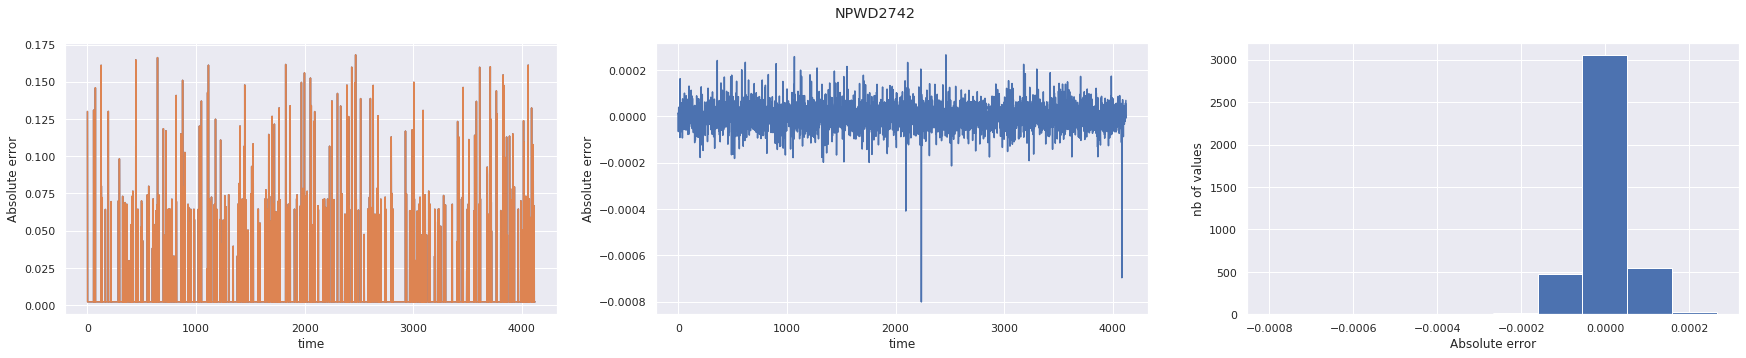

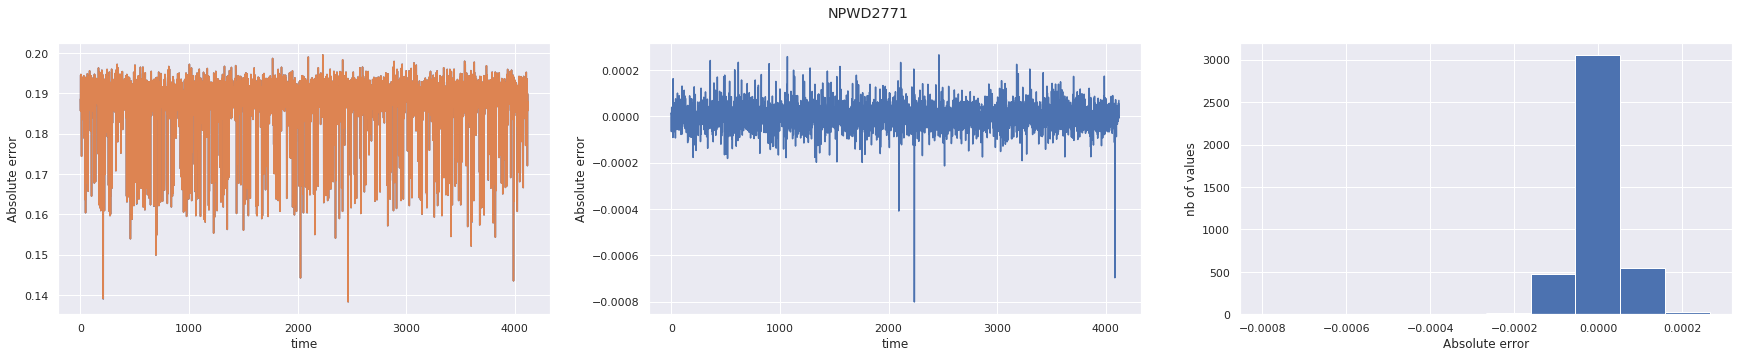

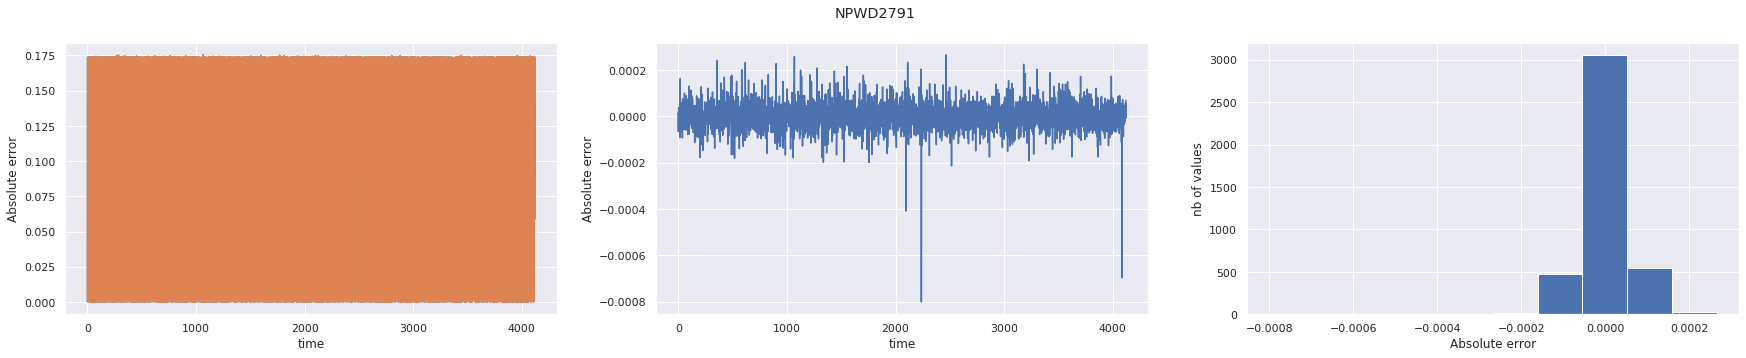

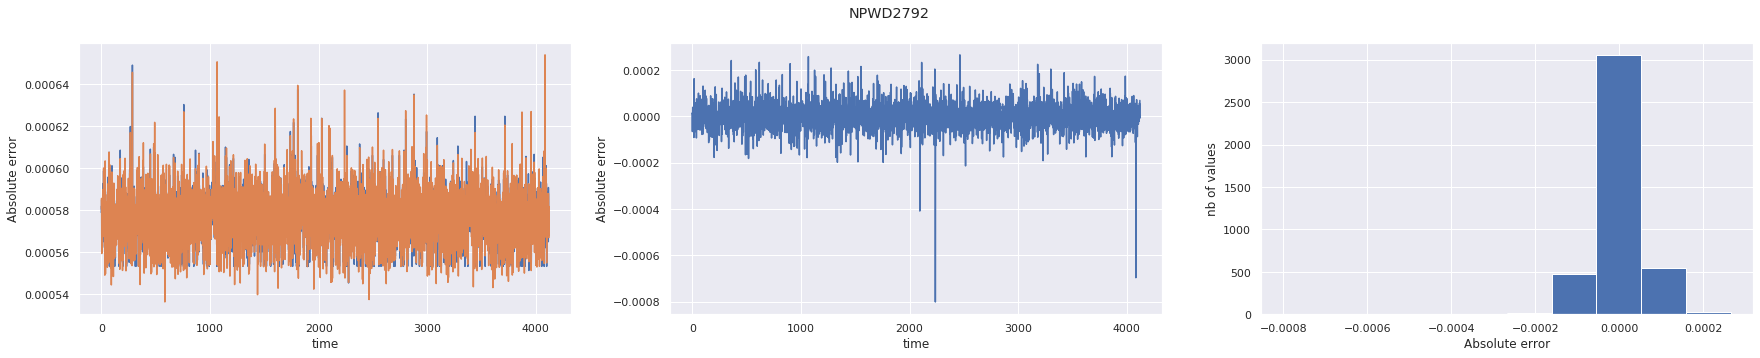

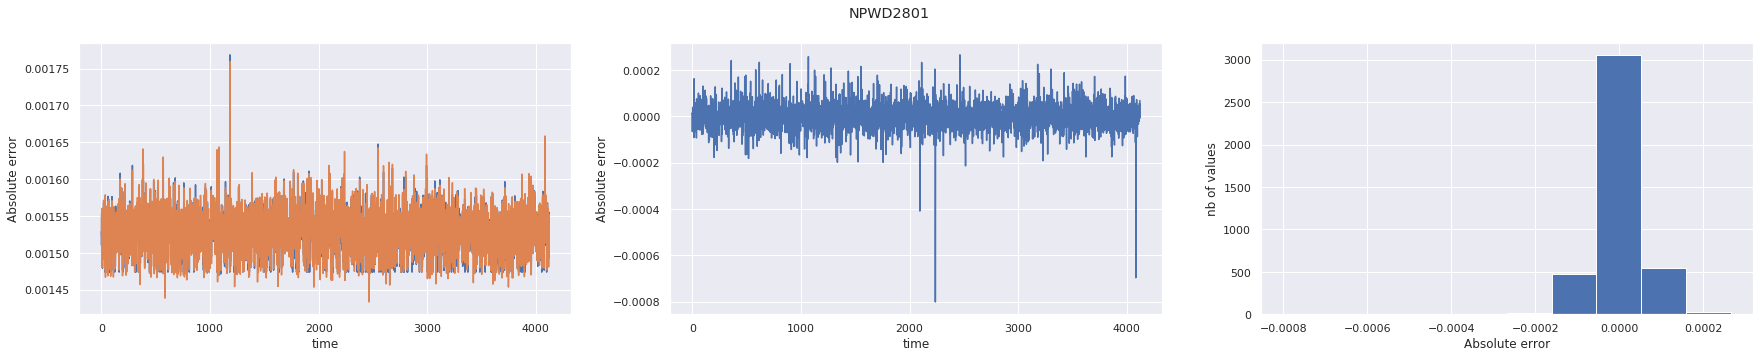

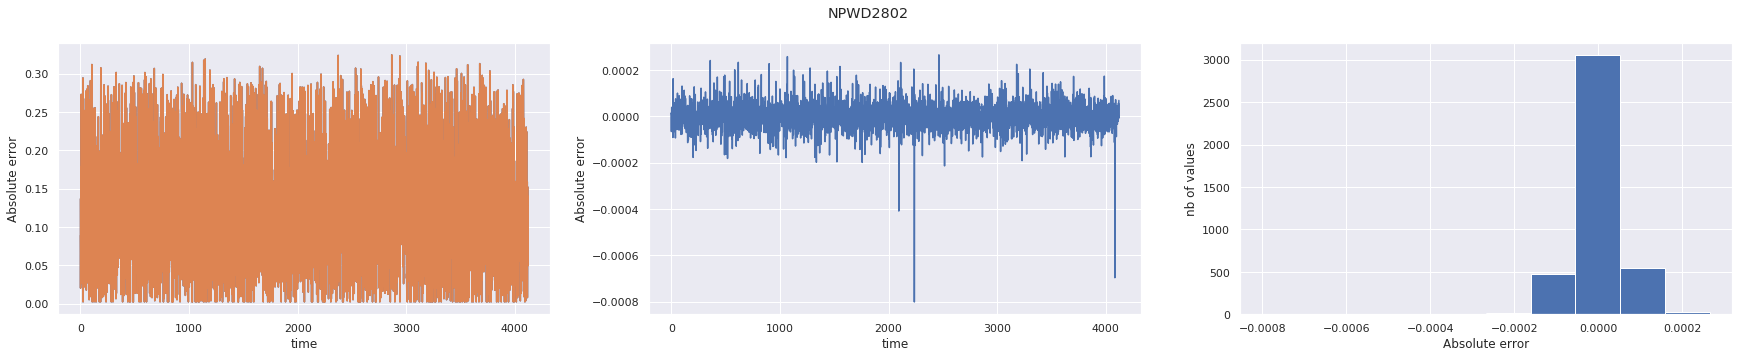

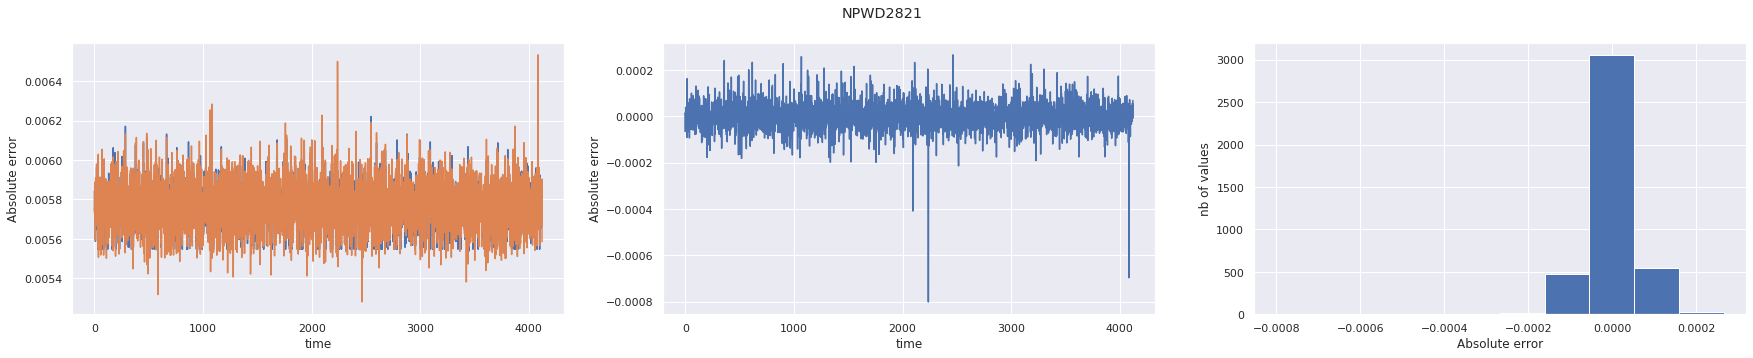

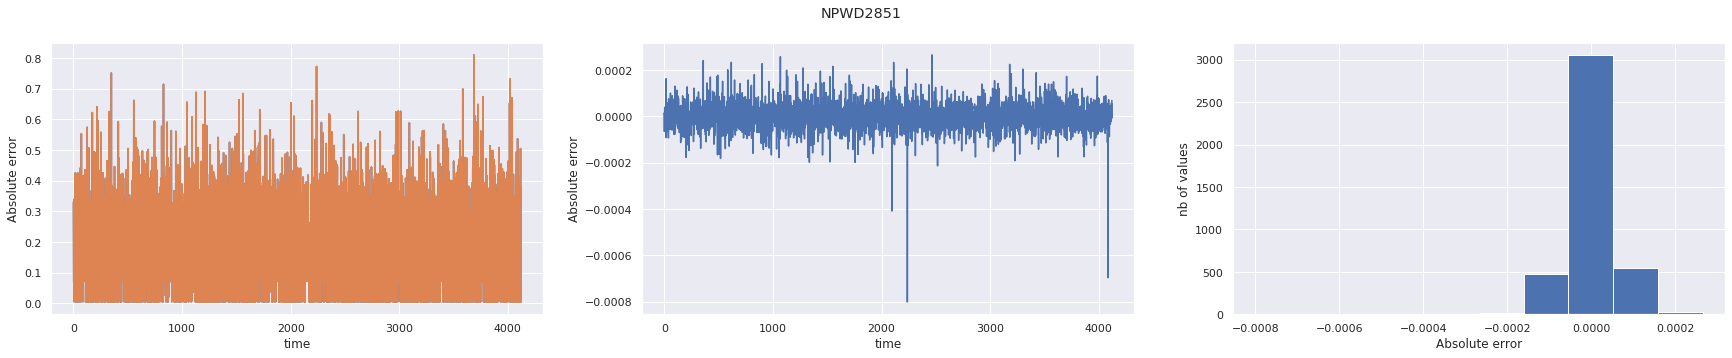

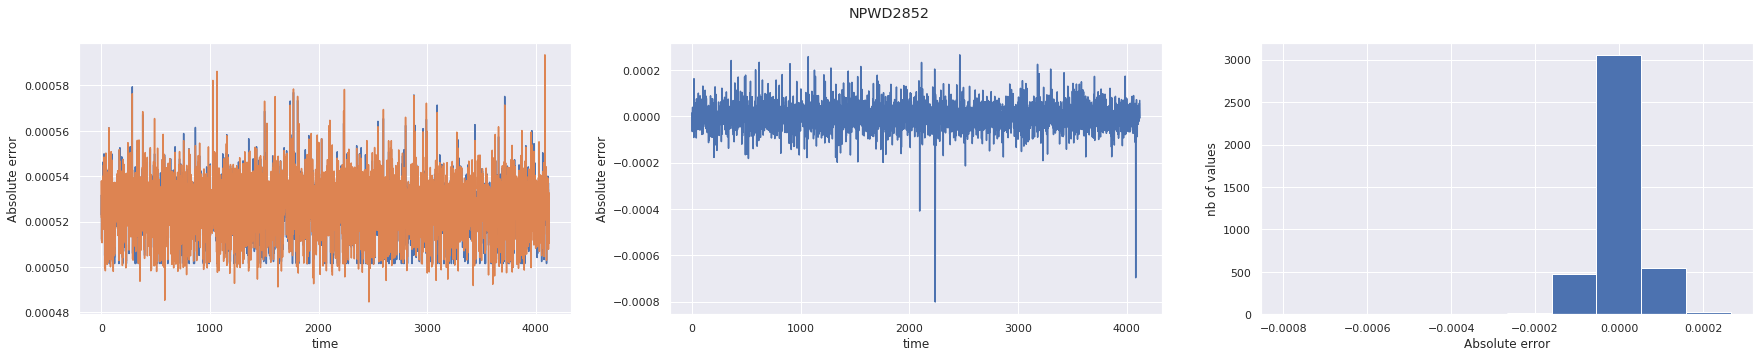

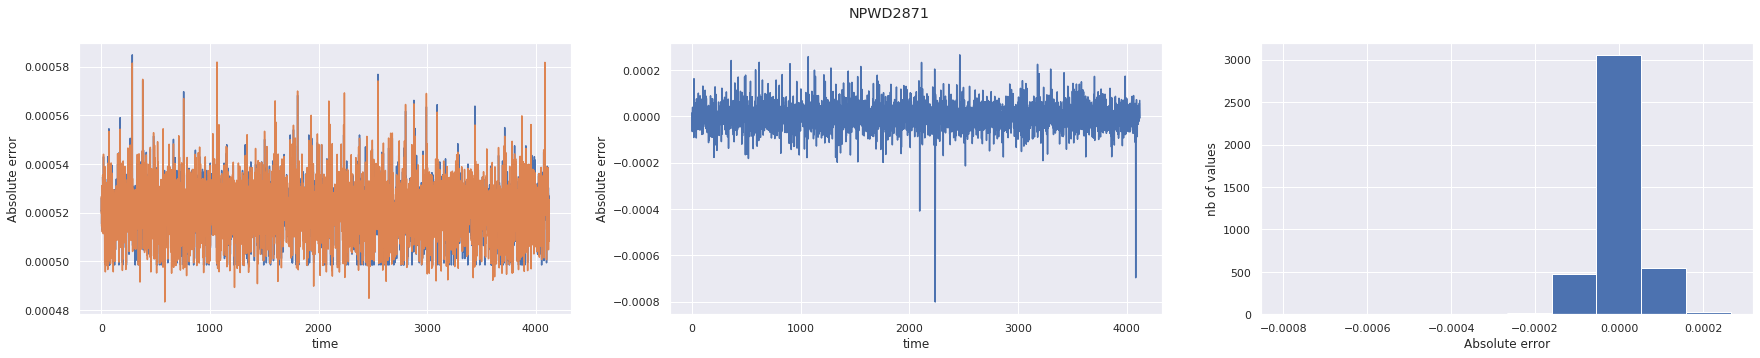

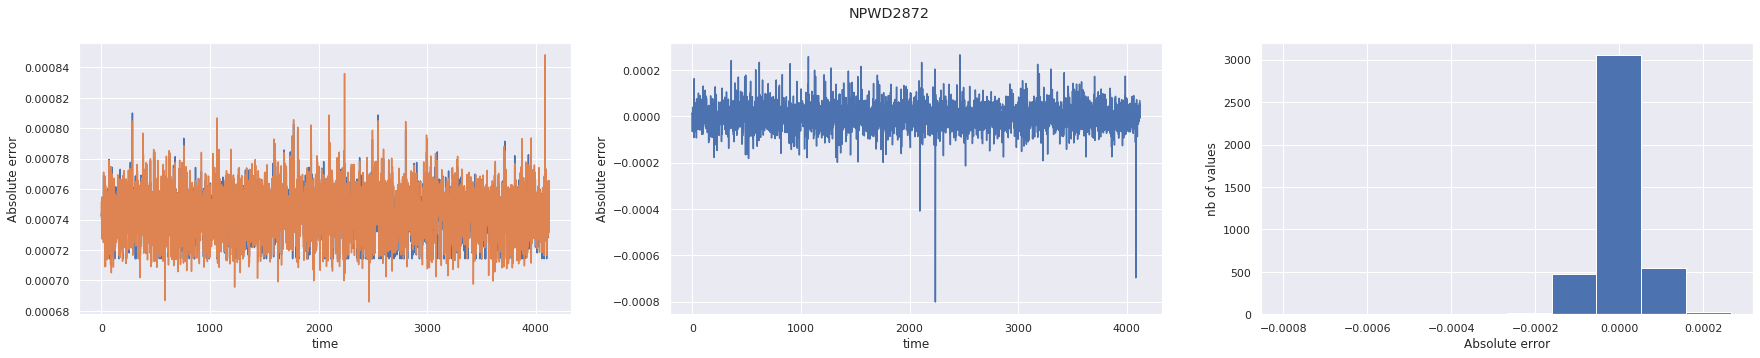

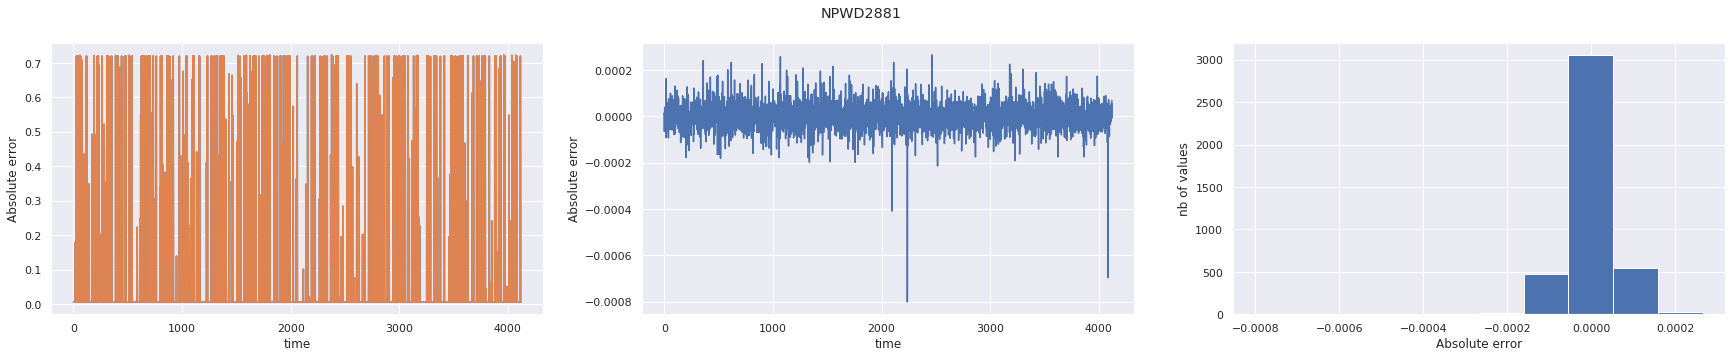

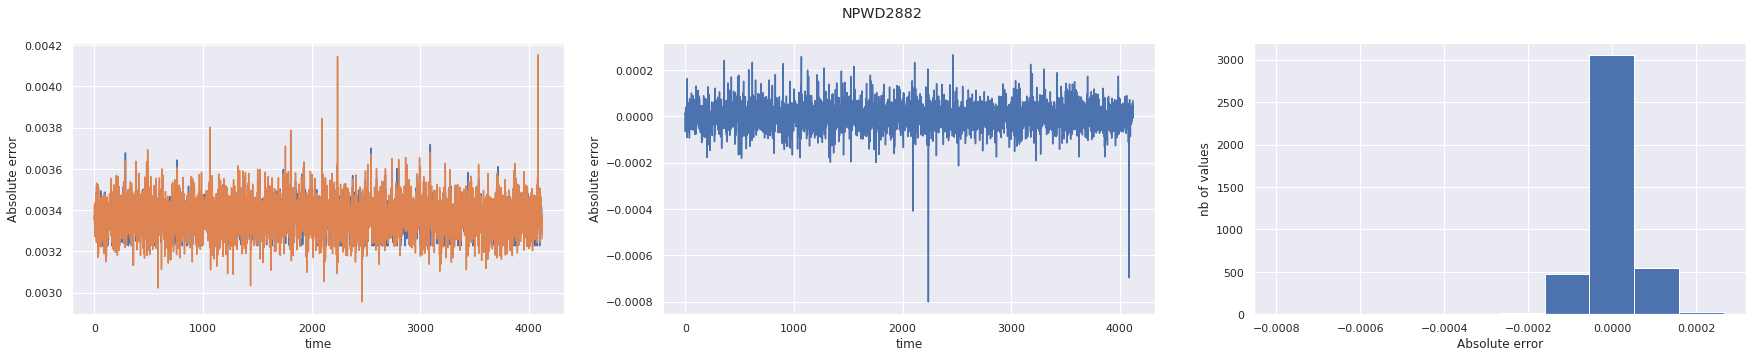

In [74]:
for power_var in power_variables :
    X_train, X_test, y_train, y_test = skms.train_test_split(X, Y[power_var], test_size=0.25, random_state=42)
    reg = LinearRegression().fit(X_train, y_train)
    predict = reg.predict(X_test)
    predict = pd.Series(predict)
    
    fig, ax = plt.subplots(1,3, figsize = (30,5))
    fig.suptitle(power_var)
    ax[0].plot(y_test.values)
    ax[0].plot(predict.values)
    ax[1].plot(err)
    ax[2].hist(err)

    ax[0].set(xlabel = 'time', ylabel = 'Absolute error')
    ax[1].set(xlabel = 'time', ylabel = 'Absolute error')
    ax[2].set(xlabel = 'Absolute error', ylabel = 'nb of values')
